# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [3]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
    X_hv = hv.fit_transform(toxic_data.comment_text)
    print("Shape of HashingVectorizer X:")
    print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    transformer = TfidfTransformer()
    X_tfidf = transformer.fit_transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")

    X_quant_features = toxic_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    sc = StandardScaler(with_mean=False)
    X = sc.fit_transform(X_matrix)
    print(X.shape)
    if (not test):
        y = toxic_data['any_toxic']
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [4]:
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='data/toxiccomments_train.csv', my_random_seed=70)

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [5]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 12994, 'Neg': 114662, 'TP': 6441, 'TN': 57428, 'FP': 57234, 'FN': 6553, 'Accuracy': 0.5003211756595851, 'Precision': 0.10115429917550059, 'Recall': 0.4956903186085886, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [6]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 12994, 'Neg': 114662, 'TP': 12913, 'TN': 114583, 'FP': 79, 'FN': 81, 'Accuracy': 0.9987466315723507, 'Precision': 0.9939193349753694, 'Recall': 0.9937663537017085, 'desc': 'svm_train'}


### MODEL: logistic regression

In [7]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 12994, 'Neg': 114662, 'TP': 12940, 'TN': 114606, 'FP': 56, 'FN': 54, 'Accuracy': 0.9991383092059911, 'Precision': 0.9956909818405664, 'Recall': 0.995844235801139, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [8]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 12994, 'Neg': 114662, 'TP': 12721, 'TN': 103334, 'FP': 11328, 'FN': 273, 'Accuracy': 0.9091229554427523, 'Precision': 0.5289617031893218, 'Recall': 0.9789903032168693, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [9]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 12994, 'Neg': 114662, 'TP': 12878, 'TN': 114571, 'FP': 91, 'FN': 116, 'Accuracy': 0.9983784545967287, 'Precision': 0.9929832677924281, 'Recall': 0.9910728028320763, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [10]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 12994, 'Neg': 114662, 'TP': 10953, 'TN': 114474, 'FP': 188, 'FN': 2041, 'Accuracy': 0.9825390110923106, 'Precision': 0.9831253926936541, 'Recall': 0.8429275050023087, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [11]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

/Users/yujunjiang/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'Pos': 12994, 'Neg': 114662, 'TP': 0, 'TN': 114662, 'FP': 0, 'FN': 12994, 'Accuracy': 0.8982108165695306, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_train'}


/Users/yujunjiang/Desktop/Machine Learning/final_assignment_1/my_measures.py:25: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


### ROC plot to compare performance of various models and fits

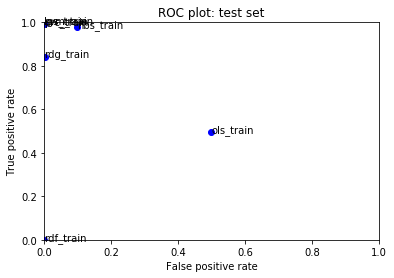

In [12]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [13]:
ols_predictions = ols.predict(X_train)

### let's look at some false positives:

In [14]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
100
Well needing residence permits is understandable (for some) but not being in Schengen benefits nobody and harms all... With Schengen there would be NO queues whatsoever which I am sure all Gibraltarians are sick of. In this case, as Gibnews has pointed out, its not Spain which is responsible for this problem...
* * * * * * * * * 
107
"

TWF Heavyweight belt

A {{prod}} template has been added to the article TWF Heavyweight belt, suggesting that it be deleted according to the proposed deletion process. All contributions are appreciated, but this article may not satisfy Wikipedia's criteria for inclusion, and the deletion notice explains why (see also ""What Wikipedia is not"" and Wikipedia's deletion policy).  You may contest the proposed deletion by removing the {{dated prod}} notice, but please explain why you disagree with the proposed deletion in your edit summary or on its talk page. Also, please consider improving the article to address the issues 

2574
I warned Consumed Crustacean in compliance with WP:Vandalism, and don't see what else I was supposed to do.
* * * * * * * * * 
2596
"

 New 2012 study by Mark Regnerus, sociology professor at the University of Texas 

A new study conducted by Mark Regnerus, an associate professor of sociology at the University of Texas has revealed, among other things, that 40% of children (aged 18 to 39) whose parents are homosexual have had an affair while married or cohabiting, compared to only 13% of children from heterosexual families. It also showed that 23% of children whose parents are lesbian or gay have been touched sexually by a parent or an adult, compared to 2% of children from heterosexual families, and that 31% of them have had sex against their will, compared to 8% from heterosexual families. The study stresses, however, that it would be wrong to conclude from its data that the abuser was necessarily one of the parents, or that the abuse had anything to do with the parent's sexual 

5125
Well, as it stands, it looks like you aren't capable of thinking for yourself.  I am not changing my course of action.
* * * * * * * * * 
5157
Please stop changing the contribution of other users. You are not an administrator, you don't have the authority to block anyone from editing, and you don't have any authority to issue 'warnings'. What you are doing amounts to trolling. Please stop it! Its fine if you put your many and varied opinions in the talk page but don't vandalize what other users have to say. Wikipedia guidelines suggest that vandalism is reverted. If you delete or modify the contribution of others on the talk page the page will have to be reverted from that point. So please just don't do it!
* * * * * * * * * 
5298
"

  The Toofy Mcjack award for dental hygeine above and beyond the call of duty You deserve one.  
"
* * * * * * * * * 
5417
I can possibly see this information being added under the Reception section which someone will probably make as the game comes c

7911
5-11-02009 
Added a minor point about the presence of catch lights in anime.  I believe that this is trivial, but deserves mentioning due to the general recognition of the phenomenon without knowledge of the term to describe it.
* * * * * * * * * 
7975
"

on a fansub of episode 176, whoever did the sub left a note at the start that read ""at least 26 more episodes of filler left"". it was only a fansub, but take that as you will"
* * * * * * * * * 
8056
Suspected sockpuppet of User:Stho002 

Report filed here
* * * * * * * * * 
8071
| caption6 = Second close on 16 March 2014
* * * * * * * * * 
8078
"

 Man, seriously, forgot the most important thing! 

Head of English Wikipedia's peer review is doing ALL the stuff, JUST to maintain his position as ""credible"" editor trying to debase British National Hero Robert Falcon Scott.

That's the key to spot the black sheep and sack all hypocritical and corruptive personnel!

But you can keep up with me to get informed about further injuri

10198
Regarding edits made during November 5 2006 (UTC)
Please do not add nonsense to Wikipedia. It is considered vandalism. If you would like to experiment, use the sandbox. Thank you.  If this is an IP address, and it is shared by multiple users, ignore this warning if you did not make any unconstructive edits. -(Talk·Desk·)
* * * * * * * * * 
10250
Billy Ayre 

I'd be interested in knowing the source you used to fill in his missing playing stats. I couldn't find them for love nor money. -  · Talk
* * * * * * * * * 
10285
"
I will repeat the important part of the tag you added:
""This template may only be used when followed by a specific description of the request, that is, specific text that should be removed and a verbatim copy of the text that should replace it. ""Please change X"" is not acceptable and will be rejected; the request must be of the form ""please change X to Y"".
If you want something changed you will need to say specifically what text needs to be changed and exactl

12512
Just like to add that the naming of this article is retarded, and full of yank bias, just because yankland called it the genesis does not mean it should be the topic title, also to apl's comment that British is a variant of English is also retarded, your simplification and perversion of our language is the only variant, end the madness rename the article to Mega-Drive82.41.107.134
* * * * * * * * * 
12540
Sorry, someone just opposed your nom at WP:ITN/C, you will have to discuss with him first...
* * * * * * * * * 
12563
"

 Citing yourself as a source? 

You appear to have written the Economic integration effects citing papers by ""R.T.Daimov"" and ""Ravshanbek Dalimov"" as the only sources. These appear to match your username - are you citing your own papers? And have you resummarised them from the article, or are you copy-and-pasting content directly?   "
* * * * * * * * * 
12592
"]]
|-
|Fabio & Romina
|
|Cha Cha Chá
|""Smooth""—Carlos Santana
|-
|Estefanía & Cristian
|
|Vals


14894
SlimVirgin informs me that she can no longer assume good faith on my part. I would take that to mean she considers us to officially have a history of dispute between us, which would indicate she cannot act as a neutral admin towards me.
* * * * * * * * * 
14899
FYI 

People have known that the Earth is spherical since Ancient Greece. On the other hand, Geocentrism wasn't abandoned until Galileo arrived on the scene...
* * * * * * * * * 
14909
ParaFN-FAL? 

Hey, I was wondering where you got [Image:ModernparaFAL.JPG] ? I've never seen an FAL like that. Would you respond on my page? I'd really appreciate it.
* * * * * * * * * 
14913
"
 ""Obviously. Its very typical of Fox,""
Please don't use Wikipedia a soapbox for your leftwing pov This is a violation and you've have been politely warned68.40.123.217  "
* * * * * * * * * 
14940
Edit wars and questions 

Hi - you posted on my talk page re: the Robert Palmer BS.  I can't see any proof that the users you mentioned were banned/blocked

17027
"Welcome!

Hello, Forcornsakey, and welcome to Wikipedia! Thank you for your contributions. I hope you like the place and decide to stay. Here are some pages that you might find helpful:
The five pillars of Wikipedia
Tutorial
How to edit a page and How to develop articles
How to create your first article (using the Article Wizard if you wish)
Manual of Style
I hope you enjoy editing here and being a Wikipedian! Please sign your messages on discussion pages using four tildes (~~~~); this will automatically insert your username and the date. If you need help, check out Wikipedia:Questions, ask me on my talk page, or ask your question on this page and then place {{help me}} before the question. Again, welcome!   "
* * * * * * * * * 
17079
"
Support per WP:NCF. '''''' Dick Laurent is dead "
* * * * * * * * * 
17113
As one of the few legitimate Astrologers on Wikipedia, I should be allowed to edit the Astrology pages, especially since there are so many unethical debunker administrator

19266
"use WP:OR (WP:IAR) or ""red links"",as needed, to nudge"
* * * * * * * * * 
19383
Like I said, the statement is sweeping. Believe it or not, the area called Celtic Europe in the article has a history of Celtic languages. Parts of Germanic Europe have a history of Celtic languages. The same goes for religion. The statement does not mention this, which is misleading. It needs to be qualified.
* * * * * * * * * 
19417
You added it again and I've deleted it again from punk rock. You need to be aware of three things—and it would help if you'd actually read the rest of the section where you've been trying to make your addition:
The entire section focuses on the emergence of scenes in countries around the world in 1977 and 1978. Bands from the 1980s aren't discussed for any country. It's not appropriate to discuss those later Brazilian bands here. Use the new Punk in Brazil article Wwwhatsup created for that.
The section introduces the names of no more than three bands per country (Fra

21685
No, not a working link, but the one must be able to identify the source. Which is not possible currently. Again, I am giving you some time to fix this. Please do so.
* * * * * * * * * 
21789
Dark side
Turn away from the dark side J.C. I know there is good in you. ;)
* * * * * * * * * 
21799
seems to be a sock created for the sole purpose of inserting the NPOV.
* * * * * * * * * 
21822
.All information you and other users have edited, are in A Pink and A Pink discography. When you add info to 2 pages, you must add info to artist's page has concerned with. That's useless and time-consuming. Artist's page should be updated when the artist has solo activities, and in Career section, not in those section you have named. If you want to improve artists' page, please add useful information, not some ugly tables. If you have information on Discography, Filmography, etc. please add them to A Pink and A Pink discography. I'm not a superior user, I don't have right to forbid other users edit

24015
nice person

Thank you very, very much you are obviously a nice person after all. I was mistaken. Here is an imaginary barnstar for you kindness.....

alpinist
* * * * * * * * * 
24022
"

One more thing. Future Studies still exist as a redirect to the main Futures Studies, in case visitors would search mistakingly for Future studies.     Wiki me up"
* * * * * * * * * 
24056
Was this one of Varsovians aims?
[]
* * * * * * * * * 
24159
Blue Balls
| note19 = featuring Slaughterhouse
* * * * * * * * * 
24160
. He called me a weirdo before I said anything bad
* * * * * * * * * 
24237
A case has been brought against you on ANI 

Cheers, good friend!
* * * * * * * * * 
24302
James u r so easy to track. U dont fool me
* * * * * * * * * 
24352
They're two different spellings of the same thing. I support the merge  .
* * * * * * * * * 
24440
Stuff them in a box
Whoever invented those cute foldable boxes was a genius.  You don't have to address concerns or comments, you just label somethin

26536
"

No Thatcher, it isnt possible that my web browser showed an incorrect version of the page, from its internal cache.  Why are you here again making up this twaddle and being pompus.  

First you make it up re the old page, then want me to apologise over something you just made up.  I think it might be good if you stop making these fanciful stories up and stop trying to stir.  You cannot see my computer settings or know that even with them set to empty, I also manually empty the cache and everything else each time I close explorer which is very very often, so that little fairy story you just spun, goes nowhere.

Internal cache reload my nellie.  Is there a disneyland article here?  How about you apologise to all who come here for that futher failed attempt at trying to cause nonsense.  If you are an admin, then time to retire perhaps, or to go be retrained.  How about you take your block tools, go find a quite contemplative spot, lock yourself into it and spare contributers here

27214
Took out the part of him being on Lil' Wayne's Carter 3.  Chris is nowhere to be found on the album
* * * * * * * * * 
27232
Psychonaut|talk]]) 14:09, 17 September 2013
* * * * * * * * * 
27234
(UTC)
One of the editors contacted me about new ideas regarding this article.  Since I've been away from the article for eight months, I saw it with a fresh perspective.  I think we went about things in a way that was too complicated last year.  This morning, I simplified the format.  I'd be interested in your opinion as to whether this reorganization improved the article or not.    19:24, 30 May 2010
* * * * * * * * * 
27252
I don't think it's an exception, when claiming United Macedonia, they usually just refer to Aegean, Vardar and Pirin Macedonia (the parts in Greece and Serbia are just included in the terms Aegean and Vardar Macedonia respectively). As long as this article says (in the note at the top) that it's about the term, the profile of Greek Macedonia really has no place here.


28956
, 6 August 2007 (UTC)
 HE can't answer by korean language. this is discussion page. also, we cal talk use a korean language. 13:18
* * * * * * * * * 
28963
"

 Opinion requested 
Since I know that you edit the areas in question, I would like to point you to a open RfC that I think your opinion would be helpful  Thanx   (powwow) "
* * * * * * * * * 
29021
"
 File:STDS9Ep107.jpg listed for deletion 
A file that you uploaded or altered, File:STDS9Ep107.jpg, has been listed at Wikipedia:Files for deletion. Please see the discussion to see why this is (you may have to search for the title of the image to find its entry), if you are interested in it not being deleted. Thank you.  —❤T☮C☺M☯ "
* * * * * * * * * 
29088
Thank you for experimenting with Wikipedia. Your test worked, and has been reverted or removed. Please use the sandbox for any other tests you want to do. Take a look at the welcome page if you would like to learn more about contributing to our encyclopedia, which you are mo

29674
Welcome!

Hello, Fronx, and welcome to Wikipedia! Thank you for your contributions. I hope you like the place and decide to stay. Here are some pages that you might find helpful:
The five pillars of Wikipedia
Tutorial
How to edit a page and How to develop articles
How to create your first article (using the Article Wizard if you wish)
Manual of Style
I hope you enjoy editing here and being a Wikipedian! Please sign your messages on talk pages using four tildes (~~~~); this will automatically insert your username and the date. If you need help, check out Wikipedia:Questions, ask me on my talk page, or ask your question on this page and then place {{help me}} before the question. Again, welcome! 

(that, by the way, was a standard message. This is not. Hi fronx!!!)
* * * * * * * * * 
29686
How can I do indicate when can't edit? I have to sign learned you observe
* * * * * * * * * 
29690
(most of which link to a clip of goths beating up emo kids)
* * * * * * * * * 
29692
2010 (UTC)


31553
^Why do you use such poor grammar?
* * * * * * * * * 
31555
"
 Crick was identified as an atheist  and ""a strong inclination towards atheism"" is atheism.  "
* * * * * * * * * 
31607
Wow...thanks for letting us share your amazing insights!! I too also hope the Cantonese language will continue to be prestigious, dominant and prevalent amongst the Cantonese-speaking people!!! I didn't realise that the 1,000,000,000 (that's one billion for those who can't count:-) Chinese people who do not speak Cantonese are so eager to join Cantonese language classes just so that they can understand Hong Kong pop music and films in the authentic original language. Obviously, reading sub-titles or watching dubbed films, or listening to putonghua versions of Hong Kong pop music would just be so tiresome!! Also I suppose schools all across China are introducing Cantonese language classes, and that parents are making sure their children are going to be fluent in Cantonese, just for the sake of their 

32120
On Ryoske's talk page,  writes I'm not sure how to translate this exactly, but it says that Kushida himself wrote the music and lyrics for France Five upon request.
* * * * * * * * * 
32168
The secession isn't going to happen.  I remeber they were discussing a secession back when Long Island seceeded in 1993, but then Portland stepped up and gave Peaks more services.  Mostly because Portland can't afford to lose the tax dollars the residents of Peaks provides.  If the debate gets to a point where a movement just might happen, I'm sure Portland will launch a counter-defensive.
* * * * * * * * * 
32172
But here we're hoping that the reader arrives at what we all know to be the wrong impression.
* * * * * * * * * 
32210
"

Tantris

Maurice Renaud;  Whistle-register nonsense

I am glad you liked the Battistini article. Please see the new Maurice Renaud creation.

I want to propose deleting category:Whistle register singers.

 

What to do about the Unchangeable??

I just happened upo

33914
What you put here are not references - they are baseless disqualification of this book. The only reference in the case of book review is the book itself - what you are diligently removing.72.75.24.245
* * * * * * * * * 
33920
Hi John,
The wording you quote is mine  the article as I found it back in July 2006 did indeed only talk about  open systems as an interoperability phenomenon, with the exception of one line:
 It can also be defined as a system that allows access by other systems, hence 'open' system.
So the article really wasn't talking about social synergy even before then  but I changed the wording precisely because I thought that aspect, although not in the scope of this article (in my opinion), was still worth discussing.  (What I had been thinking about when I did my edit was the MIT AI Lab systems that were available for open access via the ARPANET back in the late '70s / early '80s.)
I think it would be great if you could create an article to discuss the social aspec

35959
Debratna Ghosh (born 30 Septembar 1997), known as simply Debratna, is a young Indian guy who likes to develop photos and covert those into masterpices and have lots of creative ideas to share with the world. He also likes to get connected to great peoples in different parts of world.
* * * * * * * * * 
36011
There's some merit to that. But I think we should wait a bit. This article is being expanded with material for the first time in years and it'd be easier to keep it separate while its being improved. Clearly the LaRouche movment includes many discrete organizations, many of which have overlapping personnel and aims, and some of which are notable enough on their own for articles. For example, the U.S. Labor Party probably deserves an article because every little political party gets an article. OTOH, the National Democratic Policy Committee, while in some ways equally important, probably doesn't merit an article and should be covered in one of the other LaRouche articles. Most

37977
"Welcome, Devilishqueen!

I'm glad you've decided to join us - this is a great project. We do have a lot of users, and are currently working on  articles, so things can be a little intimidating! Don't worry - we love to help out, and we'll try our best to make your stay here as comfortable as possible. Here are a few links I found helpful when I first arrived here. 
Be Bold!
Don't let grumpy users scare you off
Meet other new users
Policies, guidelines, and rules 
How to edit a page and write a great article
A handy tutorial, and a picture tutorial
Writing well
Learn from others
Play nicely with others
Contribute, Contribute, Contribute!
Tell us about you
To get adopted by a more experienced Wikipedian, you could add the words {{Adoptme}} to your user page. To read more about it, go here.
You should sign your name on talk pages, discussions and votes by typing 
~~~~; our software automatically converts it to your username and the date. Also, if you don't want to jump right into e

38518
Hilary Duff's Metamorphosis album cover. 

Hey Ashuduff, I'm Quasyboy and like you I am also a Hilary Duff fan. But I just wanted to give you a heads up about your usage of Image:Hilary Duff - Metamorphosis.jpg. It a fair use image (Not a freely licensed image) meaning that it can only be used on certain pages. So its probabaly not a good idea use it on on your user page.
* * * * * * * * * 
38537
"
Thanks, the ban is the worst of all the things that have happened to me on Wikipedia. I think until and unless Wikipedia incorporates some kind of  against patent abuse of Admin privileges among other things, nobody can be editing without redundant and unhelpful apprehensions about retribution from an offended admin. Just to clarify, I am NOT trying to imply that this has happened to me, no, all I am saying is there is a possibility. (Talk?) [ (New thread?)] "
* * * * * * * * * 
38561
Illegal NPOV behavior by Rich Farmbrough (SmackBot) ==

Rich Farmbrough acting as SmackBot has dispute

40038
This is a shared Ip address. 

This ip address is owned by the University of South Alabama, and is assigned to the dorm network.
* * * * * * * * * 
40095
Thanks everyone for the help. And especially thanks to our Galician colleague, this is much appreciated. And pretty funny really when you think about it.
* * * * * * * * * 
40119
"

You like the article? Remember, Jehovah is watching you and writing down all your sins! If you like the article, then stop all the stuffy pseudo-scholar nonsense. You aren't good at it, and neither is Orange Blossom Mike. Just be real. Down to earth. A normal person. I'm trying to edit an article written by James Coram of the Concordant Publishing Concern. You folks, lacking any authority in real life, are tipsy on the authority you have here. Let all the pettifogging go. The Concordant Publishing Concern does not have ""peer reviewed books"" though it does have many books. The problem is they aren't well known so they haven't been reviewed by peers.

42410
that Beeftony started
* * * * * * * * * 
42471
, 12 April 2012 (UTC)
And now it's gone (   20:36
* * * * * * * * * 
42550
Þorgerðr Hölgabrúðr and Irpa
Sorry about adding the articles to the Reference section; I didn't realize that section is only for sources that are actually cited in the article.  I've probably made the same mistake elsewhere.  I'll try to add some substantive edits that draw on those two sources.
* * * * * * * * * 
42553
"

 Lancaster category 

There is a discussion at Category talk:Lancaster#Split category? about renaming or reorganising that category.  talk  "
* * * * * * * * * 
42562
"

Hello Mark: Excuse me, but I do not view any of the above quotes as questionable. They are the truth. Sure taken out of context to someone not familiar with the subject they may seem overly vigorous, but when faced by obvious ignorance and ineptitude I expressed myself in a forthright manner befitting an inexcusable action. You are coming in as outsiders. As far as I know on

43221
Input Requested on the template Asian Capitals 

Hello Beh-nam, I noticed that you have made previous edits to the template Asian Capitals, and I would be grateful if you could give your input to help build a consensus about the geographic location of Kabul, Afghanistan, on the continent of Asia. Thank you in advance.
* * * * * * * * * 
43236
See also: Using the python wikipediabot.  —
* * * * * * * * * 
43260
Adam Carr's photos no different to mine 

He did the same to me so why aren't you telling him the same message??? He gave me the same message and removed my tags, why can't I so the same? Is it because he is more inferior of a plebian like me and because he has royal blood that you must give him special consideration? I found it very ironic that he's a Laborite and a supporter of Australian Republican Movement, despite his sheer arrogance against fellow Wikipedians. What a show!!!
* * * * * * * * * 
43348
when the hell did i do that
* * * * * * * * * 
43357
We are going to 

45054
":Calamitybrook, you might read some of the many, many responses made over time about these issues.  You might consider wp:dispute resolution or wp:RfC to gather support for your position. However, your abusive behaviour is not likely to draw much in the way of help: see again, guidance on your talk page, this talk page, wp:COIN, wp:WQA. Please follow it.- Sinneed 

"
* * * * * * * * * 
45057
"

 April 2008 

 Please do not vandalize pages, as you did with this edit to Tiger Droppings. If you continue to do so, you will be blocked from editing.  ⊕⊗ "
* * * * * * * * * 
45145
Nativity scene
Thank you dor reviewing th article! I followed you recommendations and await your approval. Thank you again!
* * * * * * * * * 
45146
"

 original name 

I used to attend an assembly of God Church in southwest Detroit. 

My youth pastor, at the time, used to refer to a ""Challenge House"". 

They would refer to that and say it's now called Teen Challenge. Anyone know anything about that?"
* * *

47579
Look at http://www.DerHexer.Homo.com !!!! 62.158.114.87
* * * * * * * * * 
47586
"

 Straw poll and discussion concerning what outlines should be called 

A discussion is underway that may affect the name of this article.

See: Wikipedia talk:Outlines#Should articles named ""Outline of x"" be renamed to ""List of x topics""?

The Transhumanist    "
* * * * * * * * * 
47962
"
I really don't know and admit my sample size is small -). But I do believe their approach isn't satisfactory as a core foundation for the ""treatment"" section in an encyclopedia. Even if they reliably did good work, their output is not directly relevant to ""how is this disease treated?"". I think we forget that is the primary question. The ""why is this treatment recommended?"" is a secondary question which ultimately leads to the ""what evidence is there that it is effective/safe?"", along with ""is it available in my country?"" and ""what are the side effects?"", etc, etc. But sadly it seems WP medical ar

50194
RE:RfA

Yeah, sorry to waste your excellent nomination, but as I explained on the RfA, it turned into really bad timing. My RfA was swiftly becoming Wikipedia:Requests for comment/Lolicon image use, which I did not appreciate.

My only options were pretty much to either argue the point and defend myself there, which is quite frowned upon, or bow out.  talk
* * * * * * * * * 
50197
I'm all for changing it to BCE and CE from BC and AD.  -
* * * * * * * * * 
50208
"
Thanks -) But I'm not done yet... gabsadds "
* * * * * * * * * 
50243
January 2009 
 Please stop your disruptive editing. If you continue to vandalize Wikipedia,  you will be blocked from editing.    
If this is a shared IP address, and you didn't make the edit, consider creating an account for yourself so you can avoid further irrelevant notices.
* * * * * * * * * 
50296
Hi, see my response to this on yoour talk page User talk:Yoninah#Glad to see you around a bit. Best wishes and please stay in contact.
* * * * * * * * 

52572
Bedfordshire Blue Raiders 

Hello, 

I see that you merged and redirected Milton Keynes Pathfinders to a new article, Ouse Valley Eagles.
I would do the same with Bedfordshire Blue Raiders. However, I see in the history that you've already tried to and it was reverted. 

Also, I just removed some vandalism, and it is making me second guess whether to merge and redirect or nominate for deletion.

What would you suggest?
* * * * * * * * * 
52603
Re: Real Life Ministries

I am not trying to start a edit war with you, which is why I have tried to maintain most of your additions.  I don't believe some of your additions are encyclopedic or can be verifiably sourced either, but I have tried to work them in, for now, and given you the opportunity to find proper citations.  The sourcing you have tried to use thus far does not meet Wikipedia guidelines.  Please review WP:VER and WP:RS 

Thank You,
* * * * * * * * * 
52678
2 things , george i could not be more WP:Civil and as i've said befo

53644
Permanent block 

See Wikipedia:Administrators%27_noticeboard#User:PoolGuy for the reasoning.
* * * * * * * * * 
53685
It was a matter of the problem not being caught, not that it doesnt exist. Before this goest too far down the road you might look and see if the file is copyrightable, I dont think it is, see commons:COM:TOO, now that I take a second look at it.
* * * * * * * * * 
53787
"

Did you upload the image to wiki? Images displayed in wiki must be uploaded to the servers. There's a link in the sidebar that says ""upload file.""  "
* * * * * * * * * 
53822
I was quoting profanity, not using it, and that is completely different.  (Check!)
* * * * * * * * * 
53830
List of real names of professional wrestlers
Thanks for experimenting with Wikipedia. Your test worked, and has been reverted or removed. Please use the sandbox for any other tests you want to do. Take a look at the welcome page if you would like to learn more about contributing to our encyclopedia. Thanks.
* * * *

56335
a sanctioned world championship with 10x10
http://www.msoworld.com/Olympiad/titles.html#OTHELLO(10X10)
although it seems the last time was 2001
* * * * * * * * * 
56402
Thanks for your Mormonism contributions.  I hope to see more of you.  There is a Mormonism project here.  You might drop by  04:12, Jan 14, 2005 (UTC)
* * * * * * * * * 
56405
Hi, why did you delete the section about Shmuly being a convert? What was wrong with it? Thank you 184.177.112.118
* * * * * * * * * 
56427
She's denied the rumors Proof (
* * * * * * * * * 
56434
Favonian drinks Djathinkimacowboy's love juice - and makes Salvio watch jealouslyFavonian drinks Djathinkimacowboy's love juice - and makes Salvio watch jealouslyFavonian drinks Djathinkimacowboy's love juice - and makes Salvio watch jealouslyFavonian drinks Djathinkimacowboy's love juice - and makes Salvio watch jealouslyFavonian drinks Djathinkimacowboy's love juice - and makes Salvio watch jealouslyFavonian drinks Djathinkimacowboy's love juice 

57658
"
FisherQueen you totally misjudged this, but the thing is Im not bothered If I get blocked, its a light sentence, and there is something else going on. Well done anyway though. Ceoil "
* * * * * * * * * 
57689
Rajarata was abundant due to regular wars for the Rajarata land. Sinhalese kings tried to re established Rajarata, but they weren't allowed by Pandyan empire. They had full control of the Sri Lanka in 1450. They got real opportunity after 235 years from the Tamil invasion. That time people adjusted to wet zone so it is possible that descendants of the engineering families didn't had the practical knowledge to rebuild the dry zone hydraulic system. It wasn't that much simple. Even British couldn't understand how the system works. 
So clear major reason is they were adjusted to a another system. Also non existence of expert knowledge to rebuild the system could help to not to go to dry zone again.  But clearly it is not enviornmental issues. It was run more than 15 centuries

58846
"

 (sigh) First, sign your posts. Second, babbling about flaws in wikipedia makes it less likely anyone's going to listen to you. Third, please find some sources where you can find MMGS being used in place of MMORPG widely. The reason we don't use MMGS is that MMGS is a model for payment and structuring, and NOT a classification for games. That's like calling a game with lots of expansions a streamed-revenue series rather than The Sims. Talk| "
* * * * * * * * * 
58850
"

 History does not start with XP 

Continuous integration has a longer history than this article indicates.  Integration has been performed on software projects for a long time.  A number of the elements that are now seen as continuous integration were described by Booch. 

In the context of continuously integrating a system's architecture, establish a projects rhythm by driving to closure certain artifacts at regular intervals

He then goes on to say there are three parts to this:

First, the macro process of o

59872
"Non-ISO language userboxes are .   alias Alarob 

"
* * * * * * * * * 
59904
Proposed result concerning Tentontunic 

How does this proposed remedy make sense? The Four Deuces and Tentontunic edit war over a POV tag, and you guys craft a remedy banning others not currently editing the article from contributing, because they were sanctioned some time in the past, regardless of whether they may have since reformed. I fail to see how that is rational or fair.
* * * * * * * * * 
60022
"* The paragraph added in support of Brown is sourced from the same texasgopvote.com and that also was removed for that reason.
 About this edit I'm not sure it's necessary to list ""Bitch"" along when the journalist also wrote for The Atlantic, Nerve, FHM, and other publications. Better to just say Texas Observer. While it does say she holds an MFA in Creative Nonfiction from the University of Arizona, I'm not sure why this is brought up in the article.
"
* * * * * * * * * 
60051
I didn't accuse the o

62649
Please provide the link to the wiki page. I don't remember this but I'll try to help.
* * * * * * * * * 
62772
I am sorry and I take it back. I now see that the message was indeed left
 by anon who forged the signature that linked to an ua-wiki page
where my work is being discussed by AndriyK with an extreme disrespect and foul
language. That ticked me off. There are other accusations spread at
several talk pages but, as I said, I care more about the possibility
to develop Ukrainian coverage than commenting on such attacks. The rest about
the danger to loose the collaborative spirit if this continues applies.
I once had to leave one article because of the POV-pushers and the level of personal attacks. I will try my best not to allow my self to
loose my temper and leave the Ukrainian topics altogether (hint). I hope this
will settle down and we will get another contributor for Ukrainian topics. We
need that badly.
* * * * * * * * * 
62781
"

>> I do not think Mongo, or anyone else

64911
.  Signed, Anonymous for now
* * * * * * * * * 
65043
I take Wikipedia policies very seriously. BLP in particular.  Now, about those obscene, slanderous rants?
* * * * * * * * * 
65066
can i have my accounts back plzzzzzz they inculd waffleatron, waffleatron2, waffleatron3
* * * * * * * * * 
65114
"

Hi Wikipedia is not to be trusted at all. The truth always gets edited out by the prejudices of the majority. The editors also have a lot of power to determine what version of the ""truth"" they want to present. Any facts that do not conform to their prejudices are deemed ""bias"" or ""opinions"". It is not a reliable source, but just for leisure."
* * * * * * * * * 
65120
"

 Alucard (Castlevania) GA review 

Hey, I've made a try at addressing your comments at the aforementioned article. Cheers,  (Converse) "
* * * * * * * * * 
65124
"

The only thing you added from Mao was this: ""'Politics in command' and the 'mass line' are not stressed. There is no discussion of 'walking on two 

66202
Oops! I'd missed that. Yes, the source is fine. Thanks, –  (talk) (random)
* * * * * * * * * 
66239
"

 Reverting parenthetical statements 

Regarding these reverts:

http://en.wikipedia.org/w/index.php?title=Johnny_Behan&action;=historysubmit&diff;=341431931&oldid;=341431797
http://en.wikipedia.org/w/index.php?title=Johnny_Behan&diff;=next&oldid;=341431931

While I'm pretty sure the avoidance of parenthesis is mentioned somewhere in the guidelines, if someone adds information in parenthesis, that alone doesn't make the information any less viable. It's just been styled in a less-than-ideal way, and should be reformatted, rather than reverted, if anything. Editors should be careful with reverts and not use them as a catch-all solution to any problem introduced into an article. More often than not, with a little effort, a better solution exists.  (talk) 03:16, 13 Feb 2010 (UTC)"
* * * * * * * * * 
66251
Why did you delete it, it's not fair!!!
* * * * * * * * * 
66276
"
 I tried to

67763
"

 DYK for Heidelberg Raceway 

On March 20, 2009, Did you know? was updated with  from the article Heidelberg Raceway, which you created or substantially expanded. If you know of another interesting fact from a recently created article, then please suggest it on the Did you know? talk page.  
  "
* * * * * * * * * 
67780
I can do what I want... Its my talk page!

REDIRECTballs
* * * * * * * * * 
67796
"

Domaleixo said: ""They MAY be still valid"" -> Your claim, burden of proof is on you.

RESPONSE:[]. This is the newest law available. I am just following it. Can you find a newer one?

Domaleixo said: ""The last law that deals SPECIFICALLY with the topic is the one to be followed"" -> Your claim, burden of proof is on you.

RESPONSE:Universal principle of International Law. Any Law student, of any country will tell you that.

Domaleixo said: ""That´s a heraldry principle"" -> Your claim, burden of proof is on you.

RESPONSE:Look examples of New York city, São Paulo city, Rio de

70139
"

Alberta Watson
Thanks for the spellcheck. -)   Talk "
* * * * * * * * * 
70364
Don't worry about it. This was addressed to somebody else who was using the same IP number in the past.
* * * * * * * * * 
70367
Agreed - this is an assertion so should be removed or citation given.
* * * * * * * * * 
70369
Uh, how is this name written in Russian? 8-( )
* * * * * * * * * 
70515
You should investigate the actions of Malik Shabazz. You know the reputation that Wikipedia and specific biased admins have concerning Israel and the Jews. There's no need to be intimidated by them.
* * * * * * * * * 
70532
This is not the Bowling For Comumbine article, and I have seen that movie 4 times (I own a copy) and I still can't figure out what MMoore is saying, and I'm a card carrying NRA member and a huge fan on the 2nd ammendment. -) It's funny, when we cite the science community who correctly says Ben blames the Nazis on Darwin everyone goes nuts and says we shouldn't use scientists as a source.  

72456
I found a phone number and address for a place of business listed in an article, is this something that should quickly be deleted

Do you know the policy about phone numbers and contact information on wiki articles?  Sorry to bother you with this, just didn't know the answer.  thanks
* * * * * * * * * 
72491
hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey hey
* * * * * * * * * 
72513
"
Dead black males
A ""{{prod}}"" template has been added to the article Dead black males, suggesting that it be deleted according to the proposed deletion process. All contributions are appreciated, but the article may not satisfy Wikipedia's criteria for inclusion, and the deletion notice explains why (see also ""What Wikipedia is not"" and Wikipedia's de

This article would be better with a map of the Angevin Empire.  I am new to wikipedia.  Does anyone know how to make this request?
* * * * * * * * * 
74891
One of dozens of sources supporting the material you removed.
* * * * * * * * * 
74991
That wasn't you sorry  86.57.254.215
* * * * * * * * * 
75120
Reports that Donetsk Airport has been taken by resistance 

Reports that Donetsk Airport has been taken by resistance. We should have confirmation soon.
* * * * * * * * * 
75149
Proxies
I noticed you cought quite a number of them. Is there a list for us to manage these? Such a list at my disposal would be beneficial at my quest against vandalism of all kinds.  Talk
* * * * * * * * * 
75306
I'm finished with the article for the time being. Please have a look - if there's anything or your contribution I left out and which you insist on including please state this on the talk page. However, as I see it, the only things left out are clauses that don't add any information (e.g. that the name

75754
"

I could never have come to China and had this same conversation with you. I'm Chinese. the name ""Canton"" is Chinese, and is ONLY Chinese. it has been morroewed into the English language, but will forever be Chinese. you cannot change that fact to give an aire of importance to yourself.

the application of Canton to Guangzhou is confusing like the application of Florida might be to New York

Canton doesn not mean Guangzhou in the same way that Florida cannot ever equal New York, though I'm sure there are people in the world who, like you and your forefathers, might try to mislabel out of sheer ignorance.

Canton is a Chinese word. Get over it. Find your own word. Canton has one meaning, Guangdong. or are you simply unwilling to admit that your exploitive ancestors made a mistake and actually didnt even care about it or were so preoccupied with pushing opium for sex that didnt even bother to recognize such a blatently stupid mistake which was such an integral part of their liv

TreacherousWays, the above question needs to be answered. This is the roadblock in front of us.
* * * * * * * * * 
77210
"

 Undue weight on one controversy - proposed solution 

This article has a ""Controversies"" section with several detailed sentences about the Miller-Young incident in 2014. WP:CSECTION says ""sections within an article dedicated to negative criticisms are normally also discouraged. Topical or thematic sections are frequently superior to sections devoted to criticism"" and ""Sections or article titles should generally not include the word 'controversies'.""

This article shouldn't have a standalone ""Controversies"" section; controversies should be discussed in context in the ""History"" section if they're important to the history of the university. Looking at the current ""History"" section, it's very brief - for example, there are only two sentences about the May 2014 IV killings, which is very important in the history of UCSB, and it doesn't mention the 2001 IV 

77985
Herbythyme 

Your message to the talkpage for my IP said if i have any questions, to leave them here. So my question is: why do you want to help an abusive sysop who blocks people without good cause? I had barely been on Meta, and was blocked for no good reason after making a userpage. Herbythyme is an example of the worst kind of abusive sysop, and i suspect he does this kind of thing to others. 174.141.213.14
* * * * * * * * * 
78063
Another question
Sorry to bother you again, Jimfbleak, but how do I insert a picture into the page?
* * * * * * * * * 
78196
Pavlos Xatzipantelidis 

Please do not recreat this article again, it was speedied as a non-notable biography and possible attack page. Repeated recreation of validly deleted content constitutes vandalism.
* * * * * * * * * 
78284
"*Comment:  While BeastBoy has pushed the limit with four reverts in a 24hr period, I will defend him in noting that one of those was to rescind a vandalistic edit that another editor had restored. 

79672
"
Please refrain from adding nonsense to Wikipedia, as you did to Guitar. It is considered vandalism. If you would like to experiment, use the sandbox.  (Deepu) "
* * * * * * * * * 
79750
I think that some of their position statements indicate that they would.
Forget the specific age question.  Since you said above you believe some of their positions also involve Heterosexual relations, shouldn't we classify NAMBLA as a children's right org instead of a LGBT?
* * * * * * * * * 
79963
Intercaste Marriages
What is the percentage of inter-caste and inter-religious marriages in the Goravayyalu community? If it is less than 80%, aren't they anti-social?
* * * * * * * * * 
80004
"""left to players' imaginations"". Konami has never declared her dead. Cybil's fate is obviously "
* * * * * * * * * 
80058
I'm actually not at all career-oriented, have written quite a bit of content, and have supervised quite a bit of high quality content through the USEP. Mitophagy was an article largely wr

81996
new user 

AN nucleus. Thanks for the wikipedia training! Alice
* * * * * * * * * 
82111
DreamGuy

Someone has accused  of being in violation of sock protocol. DreamGuy will need your assisstance.
* * * * * * * * * 
82227
Information about the articles
* * * * * * * * * 
82385
"
See Category:Redirects with old history for an explanation.  I know I learned something! -mt "
* * * * * * * * * 
82390
Leave the bit in bout will larsen its soo true
* * * * * * * * * 
82406
"

Speedy deletion of Lucinda Scala Quinn
 A tag has been placed on Lucinda Scala Quinn requesting that it be speedily deleted from Wikipedia. This has been done under section A7 of the criteria for speedy deletion, because the article appears to be about a person or group of people, but it does not indicate how or why the subject is notable: that is, why an article about that subject should be included in an encyclopedia. Under the criteria for speedy deletion, articles that do not assert the subject's importance or

84611
"

You are not neutral at all which is a big violation, refuses to talk without involving religion, ethnicity and politics, do not care on warnings i have gave you. Most administrators here are conspirators and are working for the Zionist lobby for whitening the ugly face of ""Israel"". Let Wikipedia be free!! Refrain from making racial questionable edits full of hate.  "
* * * * * * * * * 
84663
I was too hasty in my post above. After a while, I too have grown used to this new setup. While I still dislike the lack of chronology, if this is what the majority wishes for I am happy for this format to stay. Of course, examples such as the boost of Dangerous sales after the Oprah interview, will not be able to be accurately written, but this is relatively minor.
* * * * * * * * * 
84700
It is poor because it was written by a non-notable individual and seems to fail WP:NBOOK, WP:FRINGE, WP:UNDUE and WP:GNG.
* * * * * * * * * 
84718
or like Rosie O'Fat likes carpet!!!!!
* * * * * * * *

86968
Please stop removing sockpuppet templates from userpages.  If you continue, you will be blocked.  Thank you, Talk
* * * * * * * * * 
87024
I don't see anything obvious, but let me know if I'm missing something or there's anything else I can help with. —'''''' (talk)
* * * * * * * * * 
87039
"
I would suggest we adjust the wording and use ""quit"" instead.  I don't really want to get bogged down in a multijurisdictional legal debate on here, but the CMC is confusing - one can resign from a Research Lodge (specifically permitted), and one can resign or be removed from the jurisdiction in reference to one's office, so I have no idea what's allowed and what's not.  I think we need to fiddle with wording, because CMC doesn't make sense, and it not making sense doesn't make sense either.   "
* * * * * * * * * 
87073
No. I believe Gajdusek's 'Ash of Hamster' experiment proves more than he claimed in his title: The cause of scrapie iz inorganic. Even viruses need both DNA and protein, an

89389
Um... I didn't know I messed up your sig.  Please just calm down.  And please don't block me for asking you to calm down.
* * * * * * * * * 
89402
He refused to put a separate heading for individualist anarchism.
* * * * * * * * * 
89471
would you please check this edit? 

Hi,

I'm really needing a second opinion on this edit. It's a bit important, I'm afraid.If you could see your way 'round to looking at it, I'd be in your debt. Later!
* * * * * * * * * 
89604
Hi Darwinek, 

Thanks again for working on rivers. I hope NHK will broadcast some more shows for you! It sounds like an interesting series.

The caption of the photo says something like this: 

The Kuma River near Shiroishi Station on the Hisatsu Line  

Ashikita, Kumamoto in Ashikita District, Kumamoto and Kuma, Kumamoto in Kuma District, Kumamoto  

肥薩線白石駅付近の球磨川　熊本県葦北郡芦北町／球磨郡球磨村

Best regards,
* * * * * * * * * 
89630
March 2009 (UTC)

Thank you.  For whatever it is worth, I was trying to add detail to the article before

91997
Look up
In the section above I brought you a citation about etymology, you still didn't answer, it is one month old. You want to keep your text with such a behaviour?
* * * * * * * * * 
92062
"

 How is this article U.S. biased?  

I think the U.S. bias template should be removed because the article is not U.S. biased. As stated on the template ""This article or section deals primarily with the United States and does not represent a worldwide view of the subject."" The article has no pictures of American street lights and has little mention of the history of street lights in the United States as a separate article has been created for that. The actual word ""United States"" appears only twice in the article, ""Australia"" ... over 5 times. This article is more Australian biased than American biased. The user who frequently edits this article (Bidgee) is from Australia and obviously wants this article to have a lot of information about street lights in Australia. I see no U.S. bia

94370
MIT 
Reverted page after extensive edits by me to improve organization and flow of article. No other editors or contributors have had a problem with my edits.
* * * * * * * * * 
94385
Reply 

Naghma is well known in the Pashtun world, not only in Afghanistan but Pakistan as well since her husband is pakistani. Janghair khan is not well known among pashtuns my friend. Salman Khan and Sharukh khan may have pashtun ancestry but that is only partial and their mothers were indian, therefore they cannot be put into that list since this is about Pashtuns who have parents that are both pashtun.
* * * * * * * * * 
94416
Easily divergent Banias is about the spring and water and not a city. While Caesarea Philipi is a great city. Both articles are quite separate and independent..Therefore do not support...
* * * * * * * * * 
94431
"

""Blocks are used to prevent damage or disruption to Wikipedia; they should not be intended as a punishment"".
Most curious. My edit that was admin-reverted is

95198
"

 Steven Zhang 

I apologize if this isn't my place to speak out, but Steven really is an experienced editor; see here. Cheers, 620 (contribs, logs)help us! "
* * * * * * * * * 
95203
"Pirizcki, you know we both and other users, like the IP address who put LedRush in his place, want to eliminate the 300 million figure. I found the current consensus a small improvement on the article. Posting an estimation, however, does not necessarily mean that the two numbers should be in perfect balance. I made the suggestion to name Atlantic Records with the 200 million figure, e.g. ""according to Atlantic Records, the official worldwide sales of..."", while the 300 million figure can be left as it is, with ""while other sources."" The current status of the article leaves readers and journalists to choose between the two figures uninhibited, but disrupting the balance between the figures could work as an indication towards the more accurate number, and it's not inaccurate to name Atlantic R

96671
RVD To Go To TNA

Van Dam Has Said In Interviews That He Will Go To TNA When His Contract Expires With WWE. ( )
* * * * * * * * * 
96676
"==At least mention him as a pop culture figure not just a basketball player==

Michael Jordan is not only a worldwide popular and skilled basketball player. He has a huge influence on world popular/sports/corporate/ culture back in the 90's. How about his influence on American pop culture with the ""Air Jordans"" shoes back in the 80's/90's? It was mention on a previous Wikipedia Michael Jordan article historys but it was deleted by an anonymous person. I can understand getting rid of the Merchandise section but to get rid of ""Air Jordans?"" 

Jordan's Skills

"
* * * * * * * * * 
96689
"

Ormewood is correct that later revisions by someone (to put all wind considerations into one section) caused a loss of continuity. I was the original author of the section ""Shape of The Tower"" in March of 2007, so I know that the orphaned sentences answer 

97595
"

Since this person never actually transititoned, was a minor, and never changed their name anywhere besides tumblr, why are they consistently being referred to as ""Leelah?"" Their legal name is Joshua. Either delete the article or make it searchable under both names."
* * * * * * * * * 
97616
Unblock Request

I am really sorry. Can you unblock me. I will not leave comments like that anymore. I will stay away from the Islamism page since there is no use to editing it anymore and I dont think it is that serious. So i'll promise i'll stay away from the page and the other editors from that page. I'll just do the positive contributions I had been doing earlier, before I saw the Islamism page. lease unblock me. I have learned my lesson and I will not do that anymore.
* * * * * * * * * 
97624
"

 542nd Parachute Infantry Regiment (United States) Article 

Ian Rose,

Article: 542nd Parachute Infantry Regiment (United States)

I feel that this article needs a picture and a Military Uni

98954
"

Again, not that natal women have the same HIV risk as TG/TS women... but rather that the total number of females contracting HIV is the same as the total number of MSM contracting HIV.  Source? http://www.avert.org/usastatg.htm Looking over the data, sorry, I correct my statement.  Being female who only has risky heterosexual sex has the same HIV contraction rate as being a male drug user.  Both total populations are unknown however.  Again, my assertion stands, many TG/TS are not males, and thus are not MSM.  Your own sources state that TG/TS groups are only ""considered"" ""alongside"" MSM, not that they actually are MSM.  As to Benji: my statements were made on my own talk page, and were not intended to be neither neutral nor unbiased.  If HFarmer wished to discuss the merits of the argument in this talk page, I would have been more than civil... however, she has consistently sought to put me in the worst situation possible and provoke me into an emotional response.  My ass

99777
http://en.wikipedia.org/wiki/Special:Contributions/Dalderdj That person only moved, no asking as you say. Who's wrong here? Go and talk with him too, why only with me?
* * * * * * * * * 
99910
OK, if you approve the text, we'll let it stand.
* * * * * * * * * 
99919
Thank you very much
* * * * * * * * * 
99970
"

 talk page 

why say ""ignore all rules?"""
* * * * * * * * * 
100031
"

I think that the article's current appeal to outside rankings is far better than the previous statement of fact that Yale is ""one of the most prestigious universities in the world"".  However, as a Yalie, I am worried that this is merely a product of Yale's inferiority complex.  The Harvard article backs up its claims of prominence and prestige by noting its vast resources and award-winning faculty, not by appealing to college ranking guides.  I see no reason why the Yale article can't do the same.  "
* * * * * * * * * 
100066
Using Wikipedia for advertising or promotion
* * * * * * * * * 
100143
P

101349
Before I go on making any brilliant proposals (which I fear may insult you and lead to some sense that I'm trying to be disruptive) perhaps you would be so kind as to propose what steps you believe we should take to resolve this dispute?
* * * * * * * * * 
101444
Democrat Party 

I am not engaged in an edit war, in Democrat party (phrase), I am following wikipedia guidelines. I object to the accusation.129.133.127.244
* * * * * * * * * 
101489
Im just making a point, Rangers(old) retired the number 12 in honour of fans? Rangers(2012, Sevco Scotland, Newco, the Tribute Act) are using it, they've clearly not retired anything.
* * * * * * * * * 
101499
"

 Lebanon edits 

Hey there,
thank you very much for your edits to the article Lebanon. I just wanted to note that you marked all your edits as minor. Minor edits should be superficial edits that you are believe will be agreed upon by all editors. While I personally agree with all of your edits (and think they've been quite an impr

103529
"

This person may now be using 173.217.154.181, based on similar edits at Will Patton.  (converse) "
* * * * * * * * * 
103537
"

Gamaliel

That's understandable, between Gamaliel and the other userI have not been involved with their conversation about me.  They are ""talking"" about me on a page that's viewable by the public, if they want to investigate me and my activities, I would ask that they correspond between each other through private e-mail.  It's only fair.  "
* * * * * * * * * 
103582
Expanded scope

This article should also cover plucking in its fluvial erosion sense. I will return to improve matters!
* * * * * * * * * 
103623
2014 (UTC)
 by changing the map.   04:06, 5 October
* * * * * * * * * 
103628
Maybe that is the name his mother gave him!
* * * * * * * * * 
103664
"
I support these changes. The key thing here is the placement of the counter-narrative (or call it what you will). This is a defining element of the page and of the story. Let me explain why I thi

105944
"

When I think of Carlton (he's some clerk working in Japan, right?) and all of the holier-than-thou, superior-than-thou insults he's thrown at so many people here (the evidence is all over the place)...I just can't help but think of one of Homer Simpson's quotes:

""Everyone is stupid except me.""

99.248.67.42  "
* * * * * * * * * 
105969
Arbitration - do we need it? 

After some good sleep, I've looked at our ArbCom case from another perspective. It's, in fact, a war about a couple of links. Well, the arbitration will start in 20 hours, but I'd like to suggest the last proposal: every participant recuses himself from editing the links in questioned pages for a few months, and we just leave that to other editors. The ArbCom will accept the case, but, well, a peaceful solution might be better. I've posted more on Wikipedia:Requests for arbitration#A different view. Just think about that and about whether you really need arbitration; and, if you agree with that, just sign there

106897
The person who stole the money in the Jewelery TV scam was an employee of a private charity not the city this should be changed
* * * * * * * * * 
106959
And also 2007 and 2011 data. No changes in major rankings except 1st and 2nd (Mumbai and Delhi). So better to depend on AAI Data.
* * * * * * * * * 
107044
My 2 cents ... I agree that this was a minor event in RuneScape history.  It is already being forgotten by all but those who want to sensationalise it into something it is notm i.e. significant.  It is well covered in the construction article in the history section.  The video is not verified as authentic.  I've seen it, and it appears to be highly edited, which could drastically affect its authenticity.  Jagex has acknowledged and fixed the problem.  The coincidence that it happened on a specific date is just that, coincidence.  No one but the vandals who keep changing the article calls it the 666 massacre.  That's just silly.  Get over it and let it go.  It is not signific

108357
History of Eye Color article 

Seriously...not a good article.  No offense, but could you stick to writing entries for your own language?  Your English is about as good as that of an average 13-year-old writing a book report in a general English class.
* * * * * * * * * 
108359
What are you going to do now that you know where I live, tell all the people in New Zealand that I am a heritic, and a blasphamer and that I should be excommunicated from New Zealand, because I defied the holy priesthood of wikipedia, and wikiscience?
* * * * * * * * * 
108458
"

British English tag
Sorry no idea about Wikitionary - however I do know that the template used are seperate for the two projects. :   (Talk Page)/ "
* * * * * * * * * 
108559
"

 Arguing with a source inline is not an improvement 

 for whatever views aren't being mentioned. Merely arguing against a source from your personal knowledge or opinion is original work, not what we do here. In particular, you miss the point by noting th

109550
" (UTC)

Hey, do you prefer ""useful volume"" or ""effective volume"" when you mean the above ""capacity""? Non-native speaker asking.   01:42, 18 August 2011"
* * * * * * * * * 
109570
Terry O'Neal
Hello, and welcome to Wikipedia! We welcome and appreciate your contributions, such as Terry O'Neal, but we regretfully cannot accept copyrighted text or images borrowed from either web sites or printed material. This article appears to be a direct copy from http://www.terryoneal.com/bio.htm, and therefore a copyright violation. The copyrighted text has been or will soon be deleted.

If you believe that the article is not a copyright violation, or if you have permission from the copyright holder to release the content freely under the GNU Free Documentation License (GFDL), you can comment to that effect on Talk:Terry O'Neal. Then you should do one of the following:
Make a note on the original website that re-use is permitted under the GFDL and state at Talk:Terry O'Neal where we can 

110415
"

 Hi again Ethel

As you have requested i will quote from Brooker and Kleinig:

""As a generalisation, ""forest trees"" are single-stemmed and have a crown forming a minor proportion of the whole tree height, with the combined forest crowns occupying at least 30% of the ground cover. ""Woodland trees"" are single-stemmed although they may branch at a short distance above ground level, and have a crown occupying a major proportion of the tree height, with the combined crowns occupying less than 30% of the ground cover.

Having reflected on the above and the original edit I did I can see that there are interpretative errors in my edit. If you would like to make cleaner sense of the above in the article, as I see you have attempted in historic edits,then by all means, please,  go ahead.

Thanks

 "
* * * * * * * * * 
110485
Dude, seriously, cut it out. He left me a comment, not a warning. I am now reporting you, as you've been overly warned. Do not bother me anymore or I will als

111656
To the trangie editor, im deeply sorry. I either mucked up the name of the town, or the info i recieved from the CIA was off. Either way, im deeply sorry again. I didnt mean any harm or to vandalism your page.
* * * * * * * * * 
111694
You must also consider that Moldea has been discovered several times fabricating evidence for controversial topics and trials.  This (as they say) is not his first rodeo.  He was discovered fabricating quotes from Sirhan Sirhan in the RFK trial.  I say that his  testimony in this article only invites the conspiracy theories and should be removed. 71.42.239.130
* * * * * * * * * 
111723
THIS IS MY RELIGION 

why are your deleteing my information i am giving you guys about my city
* * * * * * * * * 
111728
removed image of the 'strange man' 

I removed that image, although it was humorous it's not really relevant overall, plus the poor guy is apparantly already ridiculed at Inciclopedia, do we really need to further humiliate him on Wikipedia as wel

112717
Nobody cares.  Seriously.  It's just self-referential trivia. Guy ()
* * * * * * * * * 
112747
"

 Seven wonders of Canada voted table 

In regards to my continual addition of a table to the section entitled ""Top 7 as voted by Canada"", I must defend my position.  Given the controversy over the judges' lack of appreciation for the voters' decision/choices, the voting section results should be given equal precedence on the page, as many (if I dare say, most) who have followed this contest feel these are indeed the ""true"" wonders of Canada, as they were voted for by Canada as a whole (the opinion of over a million voters vs. the opinion of 3 judges).  If you feel so inclined, feel free to remove the voted wonders from the ""short list"", or (and I believe this to be a superior solution) add the ""chosen"" wonders back into the short list section, as the shortlist should include all shortlisted wonders (the chosen 7 were shortlisted as the others).  I do, however, stand by my co

114024
"
I disagree with that. These templates are effectively the same as the one we just discussed, I see no need to be overly bureaucratic about that. >Radiant< "
* * * * * * * * * 
114075
Discography 

Can someone format that section? It got deleted by someone and I tried restoring it but it is definitely messed up. Also in the future, is there a way to add a section that was deleted then to go back and find the version and copy the text? Thanks
* * * * * * * * * 
114158
"

 Conceptual, logical and physical schemas
This paragraph opens with ""In 1975 ANSI described three kinds of data-model instance"".  They did but in 1975 it wasn't Conceptual/Logical/Physical as the para claims.  It was External/Conceptual/Physical, see the wiki article http://en.wikipedia.org/wiki/Three_schema_approach or look at the diagram alongside!
80.254.147.164  "
* * * * * * * * * 
114238
The trees grow back so it is all healthy.
* * * * * * * * * 
114257
More could also be added about the reactions that 

116583
" 2006 (UTC)

Once again you are being very condescending to me. Please tell me how I vandalized JzG's and your user page because I honestly don't think I did. If I did, then I guess you get the satisfaction of rubbing it in my face since you like being condescending to me, and if I didn't, I would like justification. Responses like: ""You are perfectly well aware of how you vandalized both my talk page and JzG's page"" really don't help find a solution here. I would really appreciate if you would show me proof that I vandalized. Thank you, and try using your manners next time.  02:26, 1 December"
* * * * * * * * * 
116614
"
'New' articles

I'm intending to make separate articles for each class as already exist at the german wikipedia.

Main reasons are:
I didn't find half as much info as I wanted in the article - hence I want to expand them
If I expand this article for all the classes it might become very long.
I also found the non-numerical treatment of the classes a bit confu

117945
Still pointlessly protected, with mysterious acceptance of some edits but not others.
* * * * * * * * * 
117970
"
It's right there in the article: The Wayback machine ""is maintained with content from Alexa Internet.""  Perhaps that could be expanded on somewhat, but I'm not sure how many of the details are public.   tälk "
* * * * * * * * * 
117978
, 11 March 2007 (UTC)
 There is a long section about Jewish reactions to The Passion Of The Christ, this is no different. When a racial or ethnic group is offended by a movie, such criticism should be reflected in the movie's article.  15:45
* * * * * * * * * 
118030
Look - here's one I just merged: Template:ARIA Award for Best Female Artist.  Not one of yours, but this had been made up of six component parts!!!
* * * * * * * * * 
118064
I feel your pain 

It is very frustrating. I don't know believe there will ever be a solution. It is an ancient legacy.  01:32, 28 Dec 2004 (UTC)
* * * * * * * * * 
118219
Months

Syttende mai —- the

119403
From the way I'm reading it, the name (romance, blue sky) seem to relate to the actual location being...well, romantic with blue skey...but if it still doesn't fit that section, I'll try to fix further.
* * * * * * * * * 
119424
Age of Carlsbad Caverns 

I have attempted to answer your question at Talk:Carlsbad Caverns National Park.
* * * * * * * * * 
119456
"
Yes, and? Those are the facts. A special share of the responsibility should probably go to the Commons community, which has proven itself wilfully unable to tell the difference between (NSFW) this or (NSFW) this or (NSFW) this, and sex-ed material. N466 
"
* * * * * * * * * 
119520
a screwup with page formatting andf I have just edited these posts to make the last two posts show up  )
* * * * * * * * * 
119522
Only ten minutes!! 

I am waiting, but I will add construction tmplate. But we will talk later. Not everything needs references125.25.42.129
* * * * * * * * * 
119538
"

OK I give you Greatest saying.  
But you are 

122233
article 

This article is mostly unsourced, and most of the sources are not in the mainstream.  If there was a massive murder spree by blacks against whites, I think the mainstream press would have covered it somewhat.  I am removing much of the statements without mainstream citations.
* * * * * * * * * 
122285
"
 Oh no , I am so disappointed in you! (1) Your response was not in the prescribed Limerick format, or in any form of poetry; (2) you did not explain your Edit in the Summary (diff) These two violations alone qualify you for WP:SHUN, which is great, cos then you can join me here in Solitary.

I'll get back to you later on desired Efficient Outcomes, and other terms we oughta precisely define (redudundant, but necessary) as we (inc you) write . But first:

 In the language of The Asylum, I strongly disagree with your uncertainty over the need for Reciprocity within our Kruel-Aide-drunk Community. There are just a very few things of which I am certain, but I am certain of 

123103
Feel like discussing my sandbox?
* * * * * * * * * 
123175
'Honestly examine your motivations. Are you here to contribute and make the project good? Or is your goal really to find fault, get your views across, or be the one in control?'
* * * * * * * * * 
123184
Well, I doubt that.
* * * * * * * * * 
123236
Right, it should be linked to Carnival (New Model Army), like in the discography.  I've fixed it. - Talk/Cont
* * * * * * * * * 
123296
Ceiling fan is just a background. You seem to hate ceiling fans, don't you? 166.171.57.224
* * * * * * * * * 
123298
"

 Article rating 

I placed the article as having a top rating since the tongue is a significant landmark in dentistry and greatly influences the location of teeth by providing a force to antagonize lip and cheek muscles. Also, I based my B-class rating of the article because of the large amount of information, but lack of in-line references and no section on diseases commonly affecting the tongue. -  talk "
* * * * * * * * *

124536
apology. You are an anglican priest (guffaws) who must protect fellow Christian and Bouha sockpuppet Drmaik. Why british christians keep messing with Muslim Arab articles, to the detriment of content, is beyond me.
* * * * * * * * * 
124540
I've a suspicion that there's a block-evader in the midst of the Derry discussion. Whoever it is, he/she seems to be very knowledgeable about Wikipedia, after having only been around for a few days.
* * * * * * * * * 
124603
"Thank you for experimenting with the page Blood Elf on Wikipedia. Your test worked, and has been reverted or removed. Please use the sandbox for any other tests you want to do. Take a look at the welcome page if you would like to learn more about contributing to our encyclopedia.  A link to the edit I have reverted can be found here: link. If you believe this edit should not have been reverted, please contact me.  '''''' talk. ^_^ "
* * * * * * * * * 
124622
Stop vandalising pages!
* * * * * * * * * 
124688
As you well k

126926
At least historically, Georgism was the subject of an enormous amount of criticism, in a wide range of sources. These three posts should give some sense of the traditional criticisms. It wouldn't be too hard to document some of the major debates for a Criticism section.
* * * * * * * * * 
126956
Issues addressed 

I'm just going to outline the issues I am addressing, per the last FA nomination failure, as well as advice received from a PR a while ago.
 Citations have been added
 Fair use rationales have been provided for all images
 The article is no longer 'in-universe' so to speak; it is written from a real-world perspective

Be advised that I am still doing a blitz, and the final (hopefully) FA quality article is a few days off yet.
* * * * * * * * * 
127009
I am changing the series from a trilogy to a diptych based on careful reading of the novels Hardwired, Voice of the Whirlwind, and Aristoi.  The prime mover in Hardwired is the Rock War, when the Orbitals dropped asteroid

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [15]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 3231, 'Neg': 28684, 'TP': 1569, 'TN': 14279, 'FP': 14405, 'FN': 1662, 'Accuracy': 0.49656901143662857, 'Precision': 0.09822211093026167, 'Recall': 0.4856081708449396, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [16]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3231, 'Neg': 28684, 'TP': 2112, 'TN': 27219, 'FP': 1465, 'FN': 1119, 'Accuracy': 0.9190349365502115, 'Precision': 0.5904389152921442, 'Recall': 0.6536675951717734, 'desc': 'svm_test'}


### MODEL: logistic regression

In [17]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3231, 'Neg': 28684, 'TP': 2101, 'TN': 27169, 'FP': 1515, 'FN': 1130, 'Accuracy': 0.917123609587968, 'Precision': 0.5810287610619469, 'Recall': 0.6502630764469205, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [18]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3231, 'Neg': 28684, 'TP': 2188, 'TN': 23692, 'FP': 4992, 'FN': 1043, 'Accuracy': 0.8109039636534545, 'Precision': 0.30473537604456824, 'Recall': 0.677189724543485, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [19]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3231, 'Neg': 28684, 'TP': 2112, 'TN': 27204, 'FP': 1480, 'FN': 1119, 'Accuracy': 0.9185649381168729, 'Precision': 0.5879732739420935, 'Recall': 0.6536675951717734, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [20]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3231, 'Neg': 28684, 'TP': 1812, 'TN': 28397, 'FP': 287, 'FN': 1419, 'Accuracy': 0.9465455115149616, 'Precision': 0.8632682229633158, 'Recall': 0.5608170844939647, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [21]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 3231, 'Neg': 28684, 'TP': 0, 'TN': 28684, 'FP': 0, 'FN': 3231, 'Accuracy': 0.8987623374588751, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

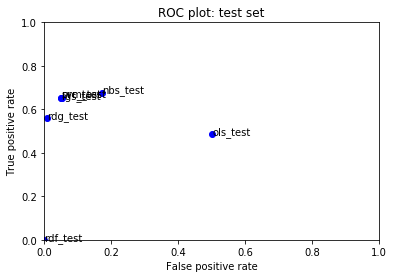

In [22]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [24]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='data/toxiccomments_test.csv', my_random_seed=70, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0          72          10
1          13           1
2          16           0
3          38           3
4           7           1
5          16           2
6          31           4
7           6       

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [25]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = ols.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.500724713379123


In [26]:
raw_data.head()

,id,comment_text,word_count,punc_count
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,72,10
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,13,1
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",16,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",38,3
4,00017695ad8997eb,I don't anonymously edit articles at all.,7,1


In [27]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,True
1,0000247867823ef7,False
2,00013b17ad220c46,True
3,00017563c3f7919a,False
4,00017695ad8997eb,False


In [28]:
my_submission.shape

(153164, 2)

In [29]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('data/toxiccomments_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation